# Heart Attack Prediction: Comparing Traditional Models with TabPFN

This notebook compares the performance of traditional machine learning models (Logistic Regression, Random Forest, XGBoost) with TabPFN (Tabular Prior-data Fitted Networks) for predicting whether a person has had a heart attack based on various health and demographic features.

## Table of Contents
1. [Data Loading and Exploration](#1.-Data-Loading-and-Exploration)
2. [Data Preprocessing](#2.-Data-Preprocessing)
3. [Feature Engineering](#3.-Feature-Engineering)
4. [Model Implementation and Evaluation](#4.-Model-Implementation-and-Evaluation)
   - [Logistic Regression](#4.1-Logistic-Regression)
   - [Random Forest](#4.2-Random-Forest)
   - [XGBoost](#4.3-XGBoost)
   - [TabPFN](#4.4-TabPFN)
5. [Model Comparison](#5.-Model-Comparison)
6. [Conclusion](#6.-Conclusion)

In [1]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"CUDA device count: {torch.cuda.device_count()}")
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"CUDA device name: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.7.0+cu126
CUDA available: True
CUDA version: 12.6
CUDA device count: 1
Current CUDA device: 0
CUDA device name: NVIDIA GeForce RTX 3070 Ti


## 1. Data Loading and Exploration

Let's start by loading the dataset and exploring its structure.

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Set plot style and color palette
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
colors = sns.color_palette("viridis", 4)

# For reproducibility
np.random.seed(42)

In [3]:
# Load the dataset
df = pd.read_csv('data/heart_2022_no_nans.csv')

In [4]:
# Drop the 'State' column as it's not relevant for prediction
df.drop('State', axis=1, inplace=True)

In [5]:
# Display basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246022 entries, 0 to 246021
Data columns (total 39 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Sex                        246022 non-null  object 
 1   GeneralHealth              246022 non-null  object 
 2   PhysicalHealthDays         246022 non-null  float64
 3   MentalHealthDays           246022 non-null  float64
 4   LastCheckupTime            246022 non-null  object 
 5   PhysicalActivities         246022 non-null  object 
 6   SleepHours                 246022 non-null  float64
 7   RemovedTeeth               246022 non-null  object 
 8   HadHeartAttack             246022 non-null  object 
 9   HadAngina                  246022 non-null  object 
 10  HadStroke                  246022 non-null  object 
 11  HadAsthma                  246022 non-null  object 
 12  HadSkinCancer              246022 non-null  object 
 13  HadCOPD                    24

In [6]:
# Display summary statistics for numerical features
df.describe()

,PhysicalHealthDays,MentalHealthDays,SleepHours,HeightInMeters,WeightInKilograms,BMI
count,246022.000000,246022.000000,246022.000000,246022.000000,246022.000000,246022.000000
mean,4.119026,4.167140,7.021331,1.705150,83.615179,28.668136
std,8.405844,8.102687,1.440681,0.106654,21.323156,6.513973
min,0.000000,0.000000,1.000000,0.910000,28.120000,12.020000
25%,0.000000,0.000000,6.000000,1.630000,68.040000,24.270000
50%,0.000000,0.000000,7.000000,1.700000,81.650000,27.460000
75%,3.000000,4.000000,8.000000,1.780000,95.250000,31.890000
max,30.000000,30.000000,24.000000,2.410000,292.570000,97.650000


In [7]:
# Display the first few rows of the dataset
df.sample(10)

,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,HadAngina,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
194767,Female,Good,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,8.0,None of them,No,No,...,1.68,113.40,40.35,No,No,No,No,"No, did not receive any tetanus shot in the pa...",No,Yes
231923,Female,Good,2.0,5.0,Within past year (anytime less than 12 months ...,Yes,8.0,1 to 5,No,No,...,1.73,104.33,34.97,Yes,Yes,No,Yes,"No, did not receive any tetanus shot in the pa...",No,No
52815,Male,Poor,7.0,10.0,Within past year (anytime less than 12 months ...,Yes,6.0,1 to 5,No,Yes,...,1.73,104.33,34.97,No,No,Yes,Yes,"Yes, received tetanus shot but not sure what type",No,No
65909,Female,Good,20.0,10.0,Within past year (anytime less than 12 months ...,No,8.0,All,Yes,No,...,1.68,127.01,45.19,No,No,No,No,"No, did not receive any tetanus shot in the pa...",No,Yes
184154,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,7.0,None of them,No,No,...,1.60,49.90,19.49,Yes,No,Yes,No,"Yes, received Tdap",No,Tested positive using home test without a heal...
89989,Female,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,7.0,None of them,No,No,...,1.68,65.77,23.40,Yes,No,Yes,Yes,"Yes, received Tdap",No,No
83642,Male,Very good,2.0,30.0,Within past year (anytime less than 12 months ...,Yes,9.0,"6 or more, but not all",No,Yes,...,1.80,99.79,30.68,No,No,Yes,No,"Yes, received tetanus shot but not sure what type",No,No
160316,Male,Excellent,0.0,5.0,Within past 5 years (2 years but less than 5 y...,Yes,6.0,None of them,No,No,...,1.93,97.52,26.17,Yes,No,No,No,"No, did not receive any tetanus shot in the pa...",No,No
55771,Female,Good,2.0,2.0,Within past 5 years (2 years but less than 5 y...,Yes,8.0,None of them,No,No,...,1.73,111.58,37.40,Yes,No,Yes,No,"Yes, received Tdap",No,No
23044,Female,Very good,0.0,2.0,Within past year (anytime less than 12 months ...,Yes,6.0,1 to 5,No,No,...,1.60,68.04,26.57,Yes,Yes,Yes,No,"Yes, received tetanus shot but not sure what type",No,No


### Exploratory Data Analysis

Let's explore the distribution of our target variable and its relationship with other features.

In [8]:
# Check the distribution of the target variable
target_counts = df['HadHeartAttack'].value_counts()
print("Distribution of 'HadHeartAttack':\n", target_counts)
print("\nPercentage distribution:\n", target_counts / len(df) * 100)

Distribution of 'HadHeartAttack':
 HadHeartAttack
No     232587
Yes     13435
Name: count, dtype: int64

Percentage distribution:
 HadHeartAttack
No     94.539106
Yes     5.460894
Name: count, dtype: float64


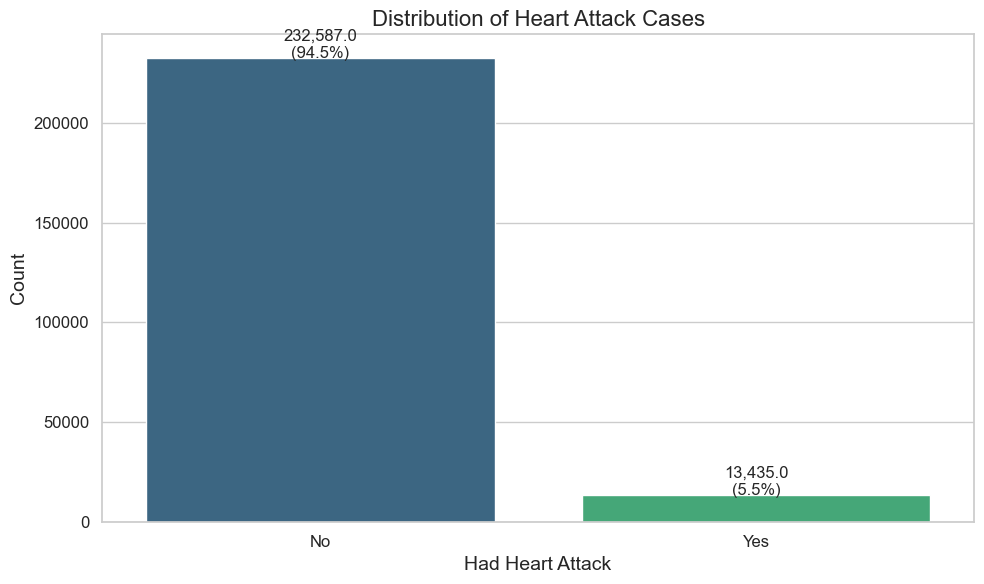

In [9]:
# Visualize the distribution of the target variable
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='HadHeartAttack', data=df, palette='viridis')

# Add count and percentage labels
total = len(df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 0.1,
            f'{height:,}\n({height/total:.1%})',
            ha="center", fontsize=12)

plt.title('Distribution of Heart Attack Cases', fontsize=16)
plt.xlabel('Had Heart Attack', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

Let's examine the relationship between age and heart attacks.

In [10]:
# Create a function to convert age categories to numeric values for plotting
def age_to_numeric(age_cat):
    age_map = {
        'Age 18 to 24': 21,
        'Age 25 to 29': 27,
        'Age 30 to 34': 32,
        'Age 35 to 39': 37,
        'Age 40 to 44': 42,
        'Age 45 to 49': 47,
        'Age 50 to 54': 52,
        'Age 55 to 59': 57,
        'Age 60 to 64': 62,
        'Age 65 to 69': 67,
        'Age 70 to 74': 72,
        'Age 75 to 79': 77,
        'Age 80 or older': 85
    }
    return age_map.get(age_cat, 0)

# Add numeric age column for analysis
df['AgeNumeric'] = df['AgeCategory'].apply(age_to_numeric)

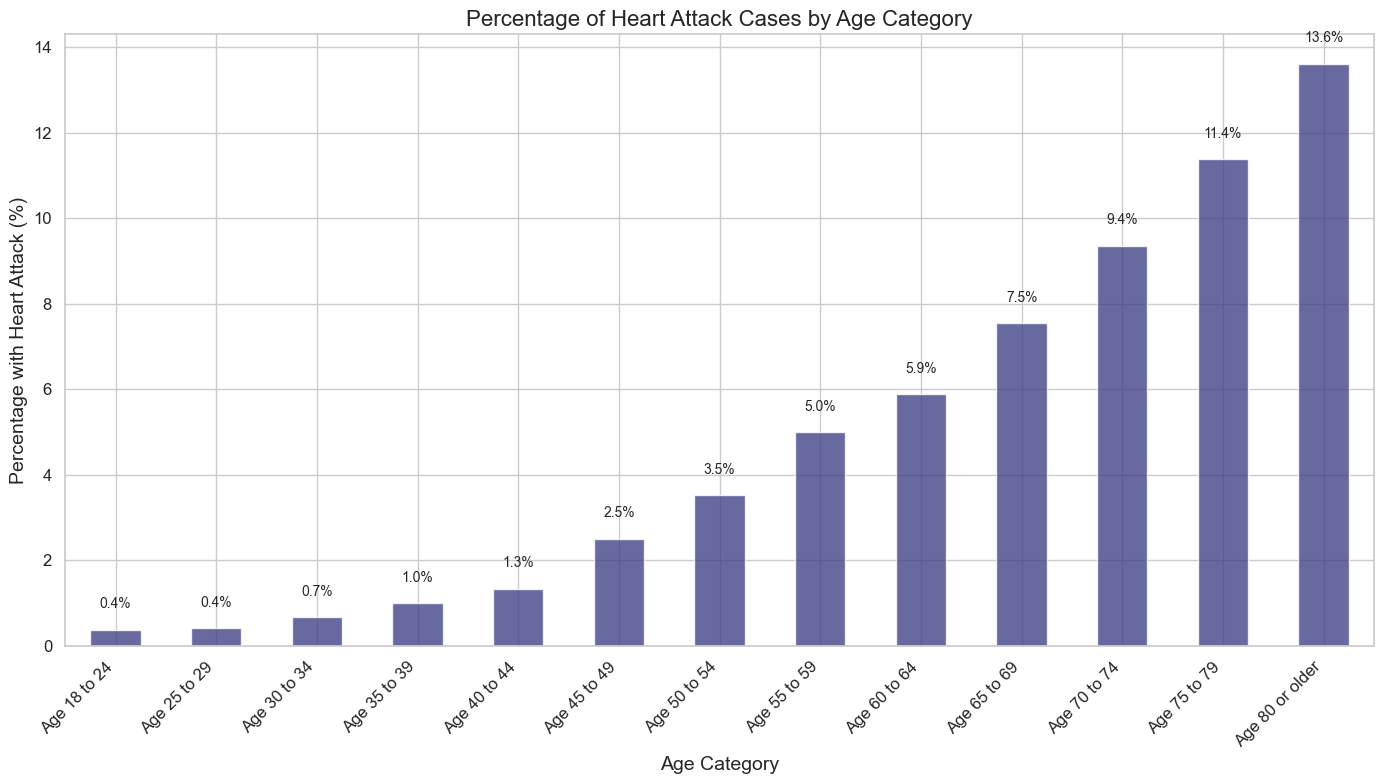

In [11]:
# Visualize heart attack prevalence by age category
plt.figure(figsize=(14, 8))
age_heart_attack = pd.crosstab(df['AgeCategory'], df['HadHeartAttack'], normalize='index') * 100

# Sort by age for better visualization
age_order = ['Age 18 to 24', 'Age 25 to 29', 'Age 30 to 34', 'Age 35 to 39', 'Age 40 to 44', 
             'Age 45 to 49', 'Age 50 to 54', 'Age 55 to 59', 'Age 60 to 64', 'Age 65 to 69', 
             'Age 70 to 74', 'Age 75 to 79', 'Age 80 or older']
age_heart_attack = age_heart_attack.reindex(age_order)

ax = age_heart_attack['Yes'].plot(kind='bar', color=colors[0], alpha=0.8)

# Add percentage labels
for i, v in enumerate(age_heart_attack['Yes']):
    ax.text(i, v + 0.5, f'{v:.1f}%', ha='center', fontsize=10)

plt.title('Percentage of Heart Attack Cases by Age Category', fontsize=16)
plt.xlabel('Age Category', fontsize=14)
plt.ylabel('Percentage with Heart Attack (%)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

Let's examine the relationship between gender and heart attacks.

<Figure size 1000x600 with 0 Axes>

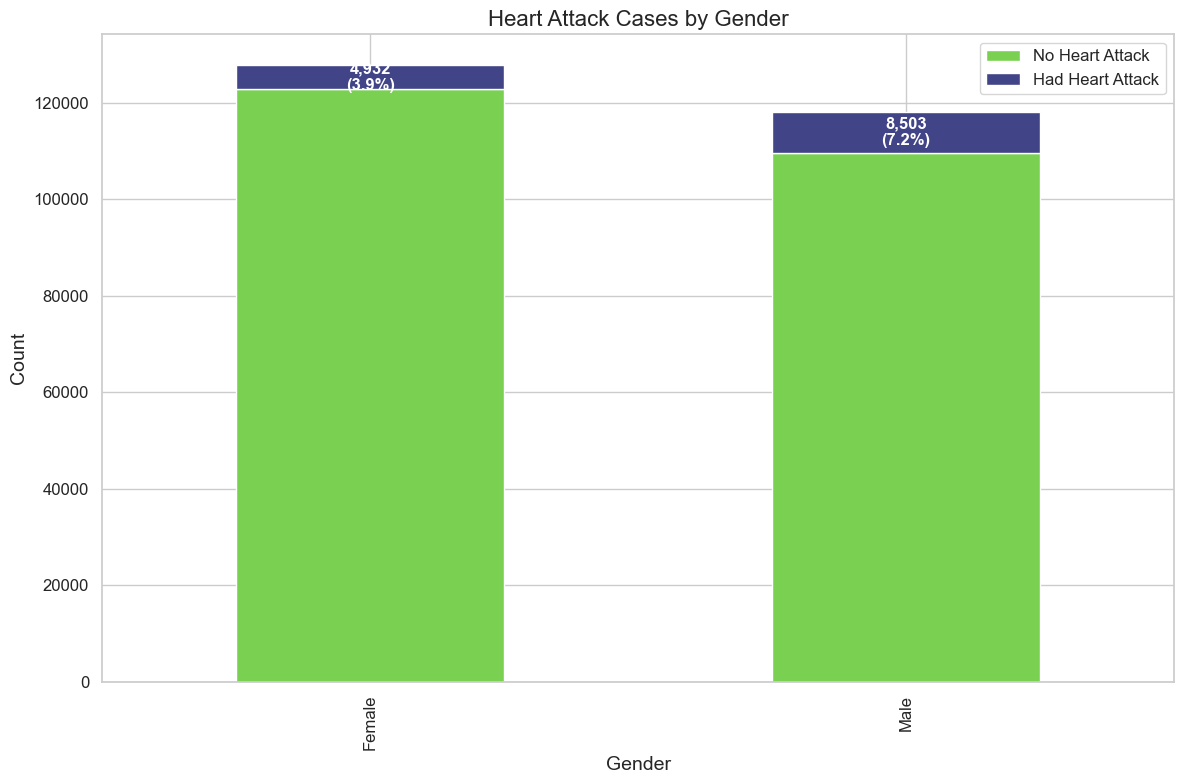

In [12]:
# Visualize heart attack prevalence by gender
plt.figure(figsize=(10, 6))
gender_heart_attack = pd.crosstab(df['Sex'], df['HadHeartAttack'])
gender_percentages = pd.crosstab(df['Sex'], df['HadHeartAttack'], normalize='index') * 100

ax = gender_heart_attack.plot(kind='bar', stacked=True, color=[colors[3], colors[0]])

# Add count and percentage labels
for i, (gender, row) in enumerate(gender_heart_attack.iterrows()):
    yes_count = row['Yes']
    total = row.sum()
    yes_pct = yes_count / total * 100
    ax.text(i, total - yes_count/2, f'{yes_count:,}\n({yes_pct:.1f}%)', ha='center', va='center', color='white', fontweight='bold')

plt.title('Heart Attack Cases by Gender', fontsize=16)
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(['No Heart Attack', 'Had Heart Attack'], fontsize=12)
plt.tight_layout()
plt.show()

Let's examine the relationship between BMI and heart attacks.

In [13]:
# Create BMI categories for visualization
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif bmi < 25:
        return 'Normal weight'
    elif bmi < 30:
        return 'Overweight'
    elif bmi < 35:
        return 'Obesity Class I'
    elif bmi < 40:
        return 'Obesity Class II'
    else:
        return 'Obesity Class III'

df['BMICategory'] = df['BMI'].apply(categorize_bmi)

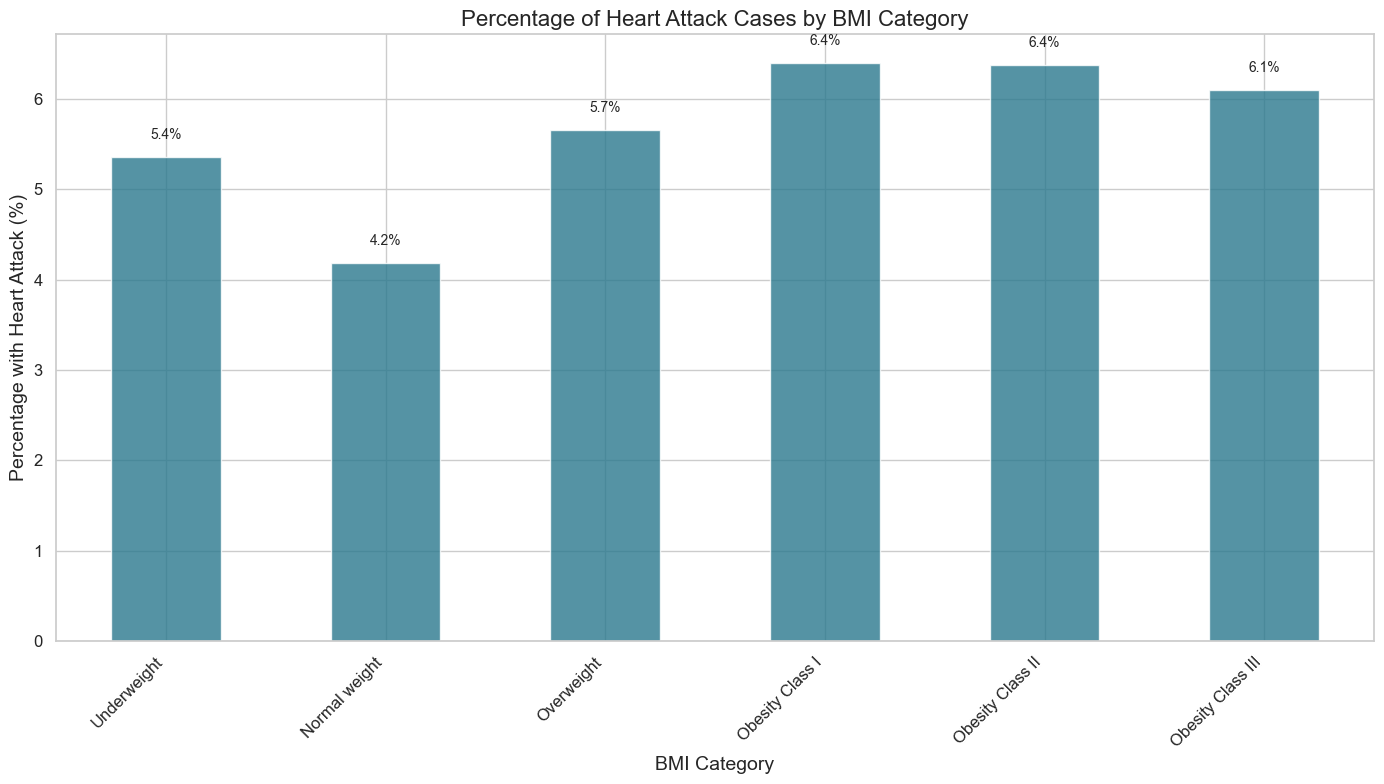

In [14]:
# Visualize heart attack prevalence by BMI category
plt.figure(figsize=(14, 8))
bmi_order = ['Underweight', 'Normal weight', 'Overweight', 'Obesity Class I', 'Obesity Class II', 'Obesity Class III']
bmi_heart_attack = pd.crosstab(df['BMICategory'], df['HadHeartAttack'], normalize='index') * 100
bmi_heart_attack = bmi_heart_attack.reindex(bmi_order)

ax = bmi_heart_attack['Yes'].plot(kind='bar', color=colors[1], alpha=0.8)

# Add percentage labels
for i, v in enumerate(bmi_heart_attack['Yes']):
    ax.text(i, v + 0.2, f'{v:.1f}%', ha='center', fontsize=10)

plt.title('Percentage of Heart Attack Cases by BMI Category', fontsize=16)
plt.xlabel('BMI Category', fontsize=14)
plt.ylabel('Percentage with Heart Attack (%)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

Let's examine the relationship between other health conditions and heart attacks.

In [15]:
# Select health condition columns
health_conditions = ['HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD', 
                     'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 'HadDiabetes']

# Calculate heart attack percentage for each condition
condition_percentages = []
for condition in health_conditions:
    # Calculate percentage of heart attacks for those with the condition
    with_condition = df[df[condition] == 'Yes']
    if len(with_condition) > 0:  # Avoid division by zero
        pct_with_condition = (with_condition['HadHeartAttack'] == 'Yes').mean() * 100
    else:
        pct_with_condition = 0
    
    # Calculate percentage of heart attacks for those without the condition
    without_condition = df[df[condition] == 'No']
    if len(without_condition) > 0:  # Avoid division by zero
        pct_without_condition = (without_condition['HadHeartAttack'] == 'Yes').mean() * 100
    else:
        pct_without_condition = 0
    
    condition_percentages.append({
        'Condition': condition.replace('Had', ''),
        'With Condition': pct_with_condition,
        'Without Condition': pct_without_condition
    })

# Convert to DataFrame for plotting
condition_df = pd.DataFrame(condition_percentages)

# Sort by the difference in percentages
condition_df['Difference'] = condition_df['With Condition'] - condition_df['Without Condition']
condition_df = condition_df.sort_values('Difference', ascending=False)

<Figure size 1400x1000 with 0 Axes>

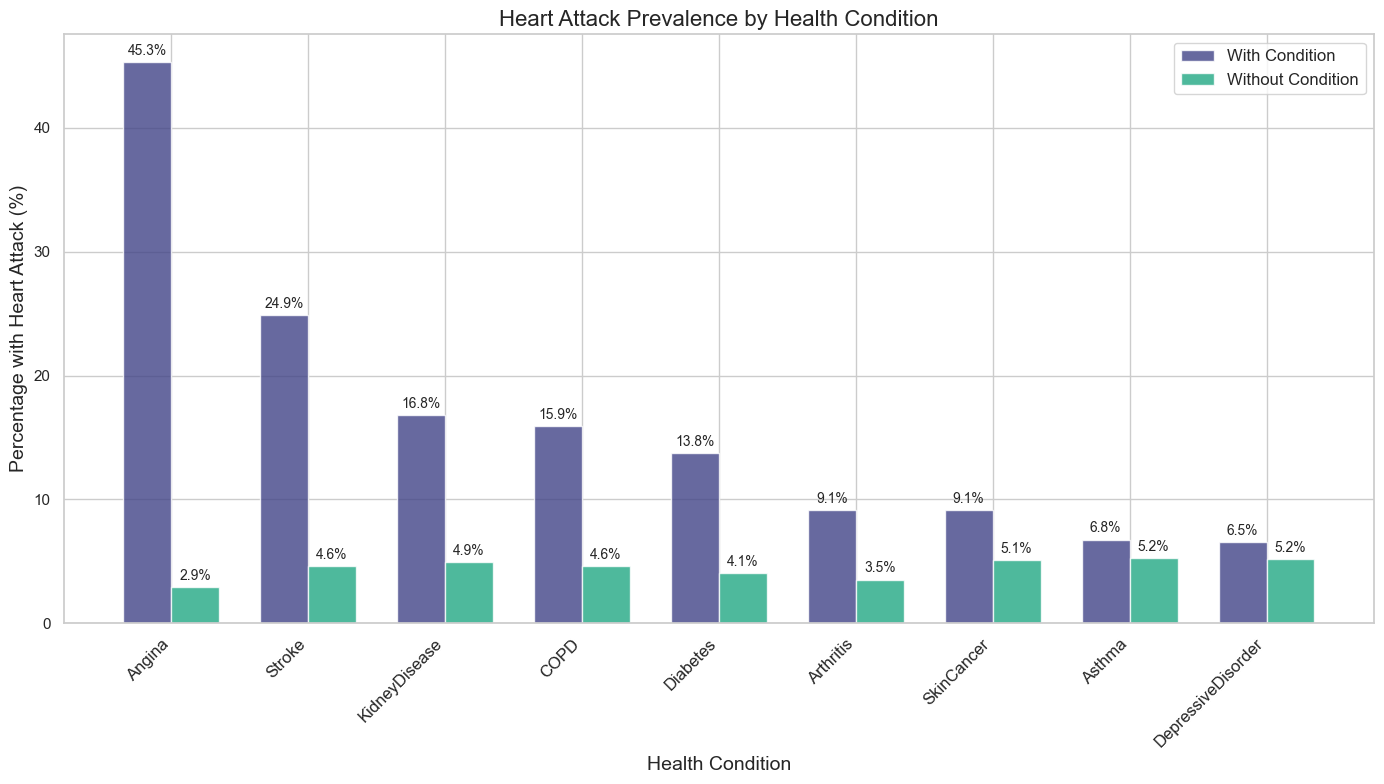

In [16]:
# Plot the relationship between health conditions and heart attacks
plt.figure(figsize=(14, 10))
x = np.arange(len(condition_df))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 8))
rects1 = ax.bar(x - width/2, condition_df['With Condition'], width, label='With Condition', color=colors[0], alpha=0.8)
rects2 = ax.bar(x + width/2, condition_df['Without Condition'], width, label='Without Condition', color=colors[2], alpha=0.8)

# Add labels and title
ax.set_title('Heart Attack Prevalence by Health Condition', fontsize=16)
ax.set_xlabel('Health Condition', fontsize=14)
ax.set_ylabel('Percentage with Heart Attack (%)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(condition_df['Condition'], rotation=45, ha='right', fontsize=12)
ax.legend(fontsize=12)

# Add value labels
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

add_labels(rects1)
add_labels(rects2)

plt.tight_layout()
plt.show()

Let's examine the correlation between numerical features and heart attacks.

In [17]:
# Create a binary target variable for correlation analysis
df['HeartAttack_Binary'] = (df['HadHeartAttack'] == 'Yes').astype(int)

# Select numerical features
numerical_features = ['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 
                      'HeightInMeters', 'WeightInKilograms', 'BMI', 'AgeNumeric']

# Calculate correlation with heart attack
correlation_with_target = df[numerical_features + ['HeartAttack_Binary']].corr()['HeartAttack_Binary'].drop('HeartAttack_Binary').sort_values(ascending=False)

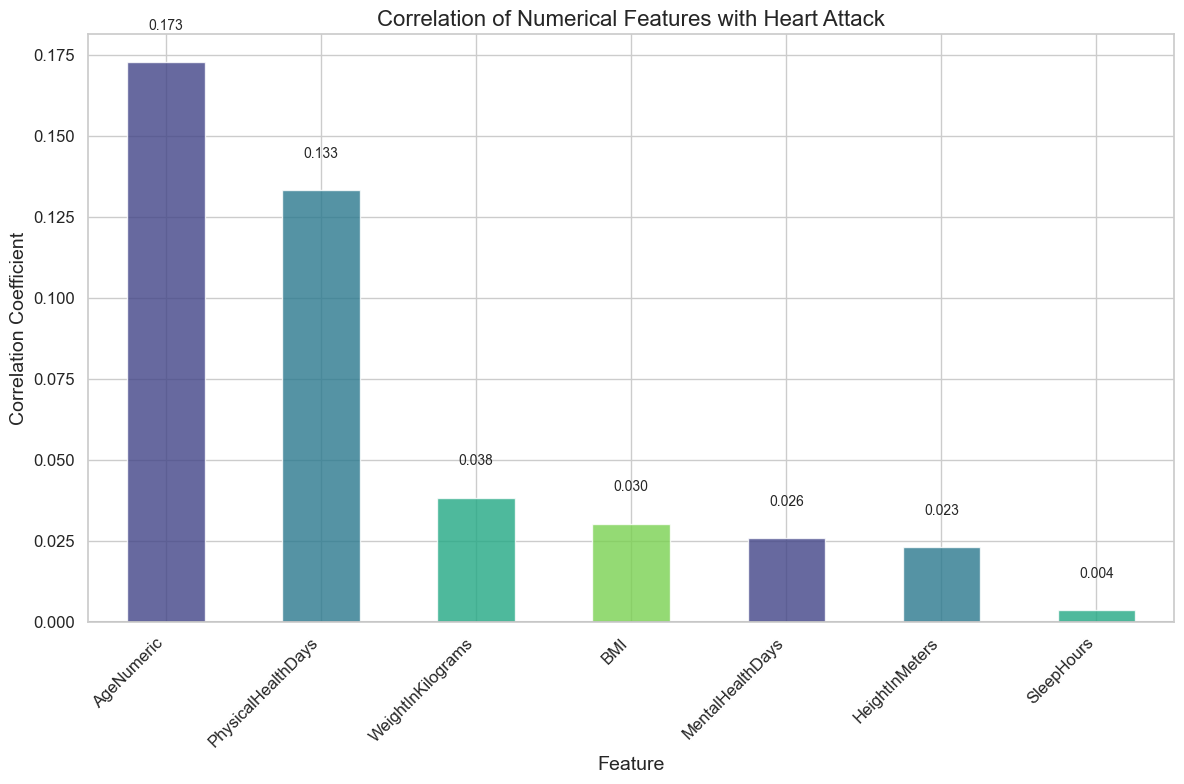

In [18]:
# Plot correlation with heart attack
plt.figure(figsize=(12, 8))
ax = correlation_with_target.plot(kind='bar', color=[colors[i % len(colors)] for i in range(len(correlation_with_target))], alpha=0.8)

# Add correlation values
for i, v in enumerate(correlation_with_target):
    ax.text(i, v + 0.01 if v >= 0 else v - 0.02, f'{v:.3f}', ha='center', fontsize=10)

plt.title('Correlation of Numerical Features with Heart Attack', fontsize=16)
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Correlation Coefficient', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

## 2. Data Preprocessing

Now that we have explored the data, let's preprocess it for modeling.

In [19]:
# Define target variable and features
y = (df['HadHeartAttack'] == 'Yes').astype(int)  # Convert to binary (0/1)

# Drop the target variable and any columns created during EDA
X = df.drop(['HadHeartAttack', 'HeartAttack_Binary', 'AgeNumeric', 'BMICategory'], axis=1)

In [20]:
# Identify numerical and categorical features
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical features: {len(numerical_features)}")
print(f"Categorical features: {len(categorical_features)}")

Numerical features: 6
Categorical features: 32


In [21]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [22]:
# Check class distribution in train and test sets
print(f"Training set class distribution:\n{pd.Series(y_train).value_counts(normalize=True) * 100}")
print(f"\nTest set class distribution:\n{pd.Series(y_test).value_counts(normalize=True) * 100}")

Training set class distribution:
HadHeartAttack
0    94.53909
1     5.46091
Name: proportion, dtype: float64

Test set class distribution:
HadHeartAttack
0    94.539173
1     5.460827
Name: proportion, dtype: float64


### Create Preprocessing Pipeline

We'll create a preprocessing pipeline that handles both numerical and categorical features.

In [23]:
# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

## 3. Feature Engineering

Let's create some additional features that might help improve our models.

In [24]:
# Function to add engineered features
def add_engineered_features(df):
    # Create a copy to avoid modifying the original dataframe
    df_new = df.copy()
    
    # 1. Create age numeric feature
    age_map = {
        'Age 18 to 24': 21, 'Age 25 to 29': 27, 'Age 30 to 34': 32,
        'Age 35 to 39': 37, 'Age 40 to 44': 42, 'Age 45 to 49': 47,
        'Age 50 to 54': 52, 'Age 55 to 59': 57, 'Age 60 to 64': 62,
        'Age 65 to 69': 67, 'Age 70 to 74': 72, 'Age 75 to 79': 77,
        'Age 80 or older': 85
    }
    df_new['Age_Numeric'] = df_new['AgeCategory'].map(age_map)
    
    # 2. Create health conditions count
    health_conditions = ['HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD', 
                         'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 'HadDiabetes']
    
    df_new['HealthConditionsCount'] = df_new[health_conditions].apply(
        lambda x: (x == 'Yes').sum(), axis=1
    )
    
    # 3. Create disability count
    disabilities = ['DeafOrHardOfHearing', 'BlindOrVisionDifficulty', 'DifficultyConcentrating',
                    'DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands']
    
    df_new['DisabilitiesCount'] = df_new[disabilities].apply(
        lambda x: (x == 'Yes').sum(), axis=1
    )
    
    # 4. Create BMI category
    def categorize_bmi(bmi):
        if bmi < 18.5:
            return 'Underweight'
        elif bmi < 25:
            return 'Normal'
        elif bmi < 30:
            return 'Overweight'
        else:
            return 'Obese'
    
    df_new['BMI_Category'] = df_new['BMI'].apply(categorize_bmi)
    
    # 5. Create health days ratio
    df_new['HealthDaysRatio'] = df_new['PhysicalHealthDays'] / (df_new['MentalHealthDays'] + 1)  # Add 1 to avoid division by zero
    
    # 6. Create vaccination count
    vaccinations = ['FluVaxLast12', 'PneumoVaxEver']
    df_new['VaccinationCount'] = df_new[vaccinations].apply(
        lambda x: (x == 'Yes').sum(), axis=1
    )
    
    # 7. Create binary features for smoker status
    df_new['IsSmoker'] = df_new['SmokerStatus'].apply(
        lambda x: 1 if x in ['Current smoker - now smokes every day', 'Current smoker - now smokes some days'] else 0
    )
    
    df_new['IsFormerSmoker'] = df_new['SmokerStatus'].apply(
        lambda x: 1 if x == 'Former smoker' else 0
    )
    
    # 8. Create binary feature for e-cigarette usage
    df_new['UsesECigarettes'] = df_new['ECigaretteUsage'].apply(
        lambda x: 1 if x in ['Use them every day', 'Use them some days'] else 0
    )
    
    return df_new

# Add engineered features to training and test sets
X_train_engineered = add_engineered_features(X_train)
X_test_engineered = add_engineered_features(X_test)

In [25]:
# Update feature lists after engineering
numerical_features_engineered = X_train_engineered.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features_engineered = X_train_engineered.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical features after engineering: {len(numerical_features_engineered)}")
print(f"Categorical features after engineering: {len(categorical_features_engineered)}")

Numerical features after engineering: 14
Categorical features after engineering: 33


In [26]:
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
X_train_enc = ord_enc.fit_transform(X_train_engineered)
X_test_enc  = ord_enc.transform(X_test_engineered)

# indices des colonnes catégo
cat_idx = np.where(
    [col in categorical_features_engineered for col in X_train_engineered.columns]
)[0]


In [27]:
from sklearn.utils import resample

pos = X_train_enc[y_train == 1]
neg = X_train_enc[y_train == 0]

neg_down = resample(neg, replace=False,
                    n_samples=len(pos)*3,  # ratio 3:1
                    random_state=42)

X_bal = np.vstack([pos, neg_down])
y_bal = np.hstack([np.ones(len(pos)), np.zeros(len(neg_down))])

In [28]:
# Update the preprocessor with the new feature lists
preprocessor_engineered = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features_engineered),
        ('cat', categorical_transformer, categorical_features_engineered)
    ])

## 4. Model Implementation and Evaluation

Now, let's implement and evaluate our models. We'll start with the simplest model (Logistic Regression) and progressively move to more complex models (Random Forest, XGBoost, and finally TabPFN).

In [29]:
# Function to evaluate model performance
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # For ROC curve and precision-recall curve
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = y_pred  # Fallback if predict_proba is not available
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    avg_precision = average_precision_score(y_test, y_prob)
    
    # Print metrics
    print(f"\n{model_name} Performance Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{model_name} Confusion Matrix', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks([0.5, 1.5], ['No Heart Attack', 'Heart Attack'], fontsize=10)
    plt.yticks([0.5, 1.5], ['No Heart Attack', 'Heart Attack'], fontsize=10, rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, color=colors[0], lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'{model_name} ROC Curve', fontsize=14)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot precision-recall curve
    plt.figure(figsize=(8, 6))
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_prob)
    plt.plot(recall_curve, precision_curve, color=colors[1], lw=2, label=f'AP = {avg_precision:.3f}')
    plt.axhline(y=sum(y_test)/len(y_test), color='gray', linestyle='--', label=f'Baseline (y_freq = {sum(y_test)/len(y_test):.3f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title(f'{model_name} Precision-Recall Curve', fontsize=14)
    plt.legend(loc="best", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Return metrics for later comparison
    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'avg_precision': avg_precision,
        'y_prob': y_prob,
        'y_pred': y_pred
    }

### 4.1 Logistic Regression

Let's start with a simple Logistic Regression model.


Logistic Regression Performance Metrics:
Accuracy: 0.8312
Precision: 0.2116
Recall: 0.7667
F1 Score: 0.3316
ROC AUC: 0.8859
Average Precision: 0.4020

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.83      0.90     46518
           1       0.21      0.77      0.33      2687

    accuracy                           0.83     49205
   macro avg       0.60      0.80      0.62     49205
weighted avg       0.94      0.83      0.87     49205



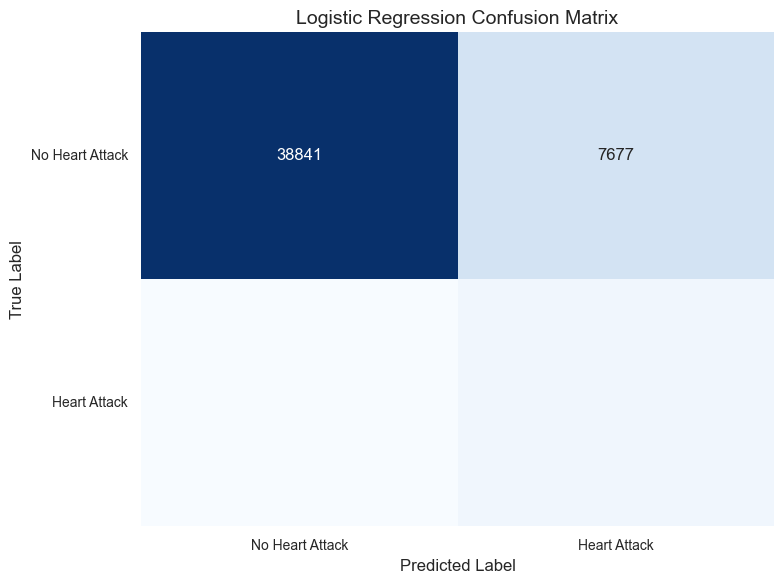

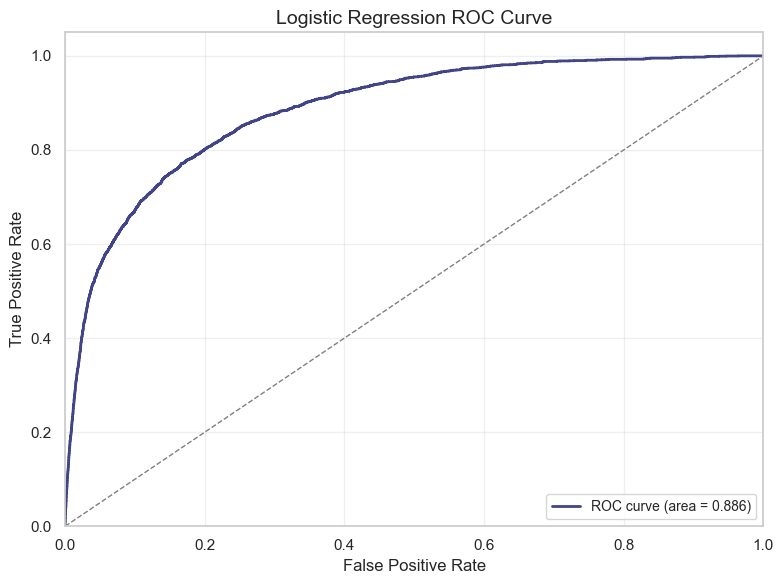

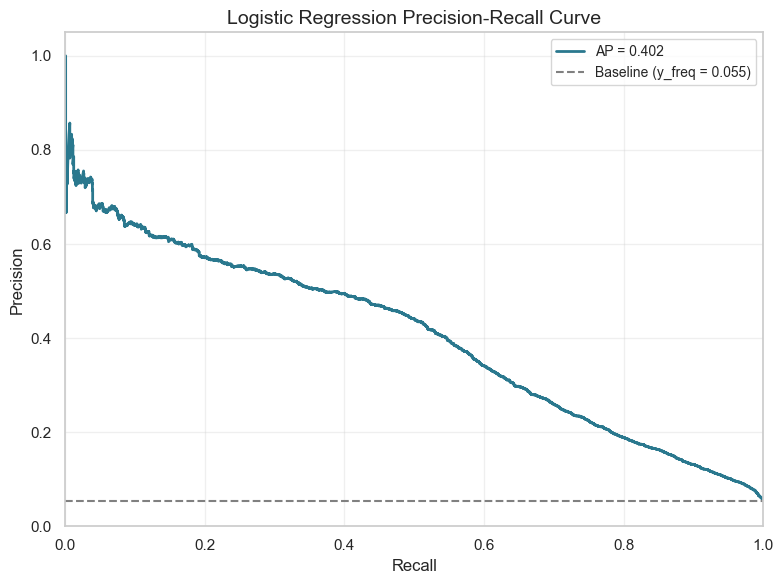

In [30]:
# Create and preprocess the data
X_train_processed = preprocessor_engineered.fit_transform(X_train_engineered)
X_test_processed = preprocessor_engineered.transform(X_test_engineered)

# Create and evaluate Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr_results = evaluate_model(lr_model, X_train_processed, X_test_processed, y_train, y_test, "Logistic Regression")

### 4.2 Random Forest

Now, let's try a more complex model: Random Forest.


Random Forest Performance Metrics:
Accuracy: 0.8572
Precision: 0.2361
Recall: 0.7220
F1 Score: 0.3558
ROC AUC: 0.8837
Average Precision: 0.3930

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92     46518
           1       0.24      0.72      0.36      2687

    accuracy                           0.86     49205
   macro avg       0.61      0.79      0.64     49205
weighted avg       0.94      0.86      0.89     49205



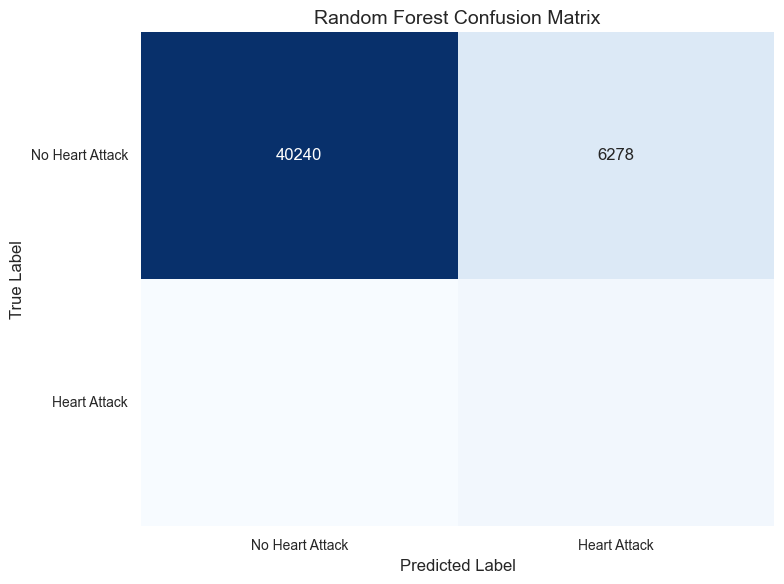

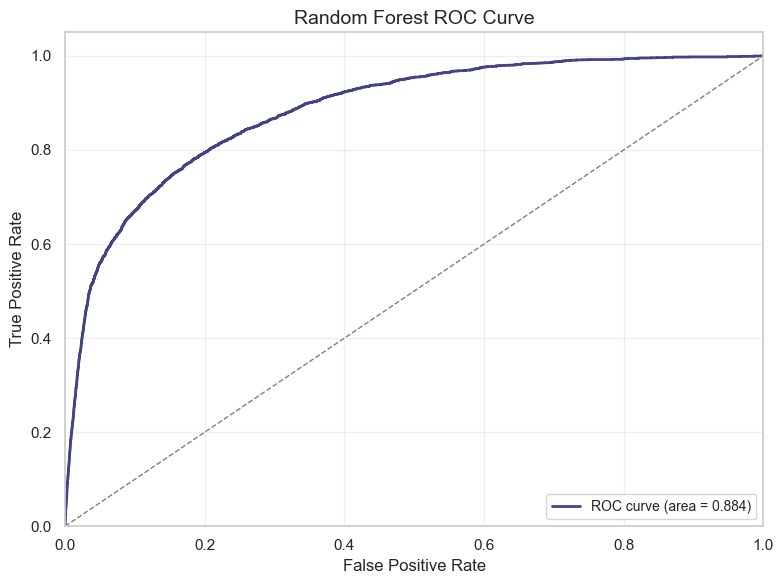

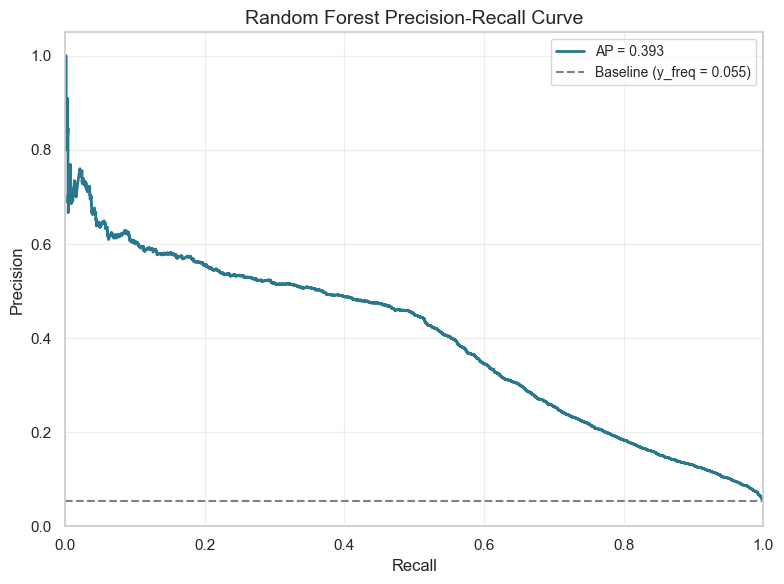

In [31]:
# Create and evaluate Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, 
                                 class_weight='balanced', random_state=42, n_jobs=-1)
rf_results = evaluate_model(rf_model, X_train_processed, X_test_processed, y_train, y_test, "Random Forest")

Let's examine feature importance in the Random Forest model.

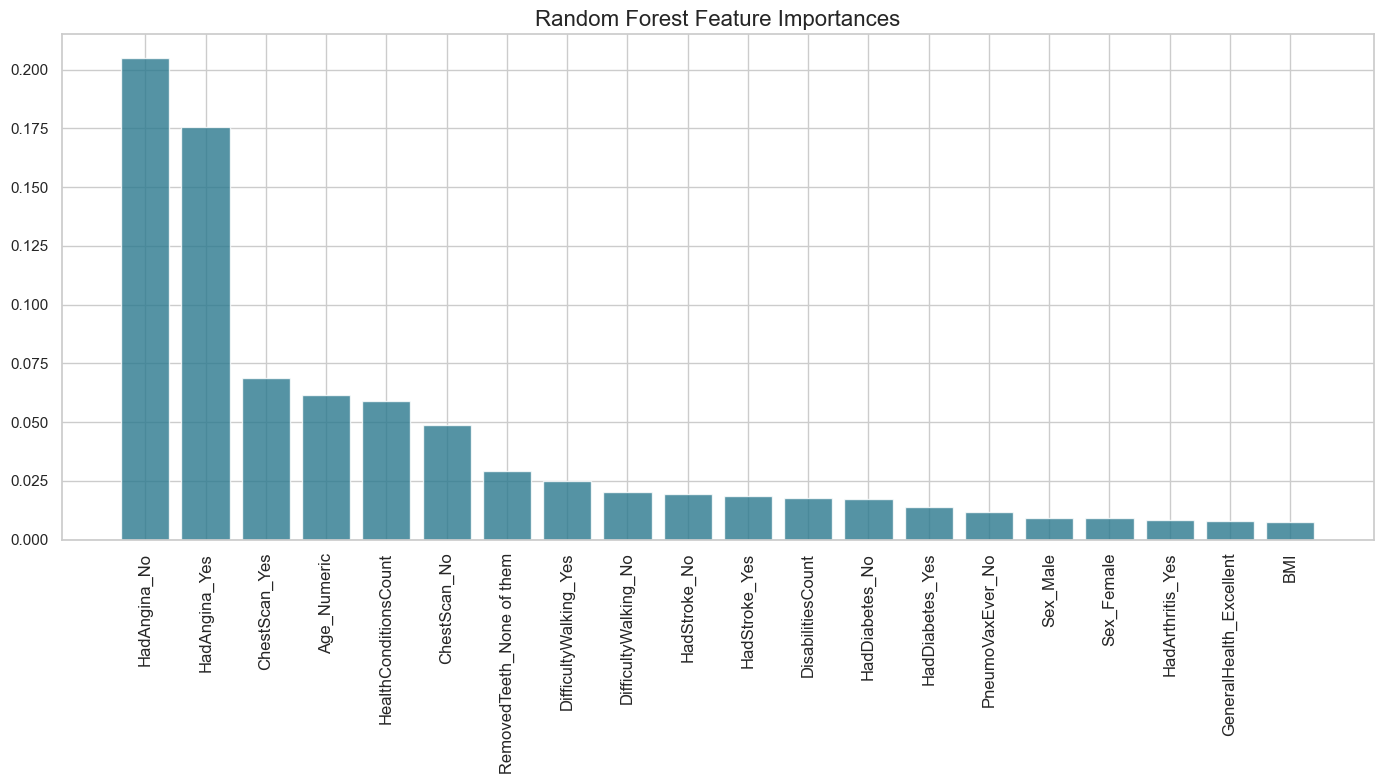

In [32]:
# Get feature names after one-hot encoding
ohe = preprocessor_engineered.named_transformers_['cat'].named_steps['onehot']
feature_names = numerical_features_engineered.copy()
feature_names.extend(ohe.get_feature_names_out(categorical_features_engineered))

# Get feature importances
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the top 20 feature importances
plt.figure(figsize=(14, 8))
plt.title('Random Forest Feature Importances', fontsize=16)
plt.bar(range(20), importances[indices[:20]], color=colors[1], align='center', alpha=0.8)
plt.xticks(range(20), [feature_names[i] for i in indices[:20]], rotation=90, fontsize=12)
plt.tight_layout()
plt.show()

### 4.3 XGBoost

Now, let's try an even more advanced model: XGBoost.


XGBoost Performance Metrics:
Accuracy: 0.8165
Precision: 0.2003
Recall: 0.7890
F1 Score: 0.3195
ROC AUC: 0.8880
Average Precision: 0.4085

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.82      0.89     46518
           1       0.20      0.79      0.32      2687

    accuracy                           0.82     49205
   macro avg       0.59      0.80      0.61     49205
weighted avg       0.94      0.82      0.86     49205



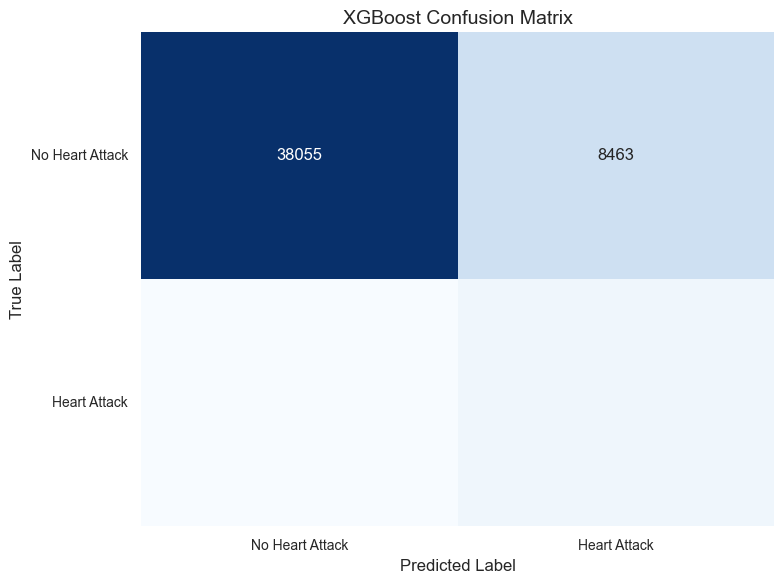

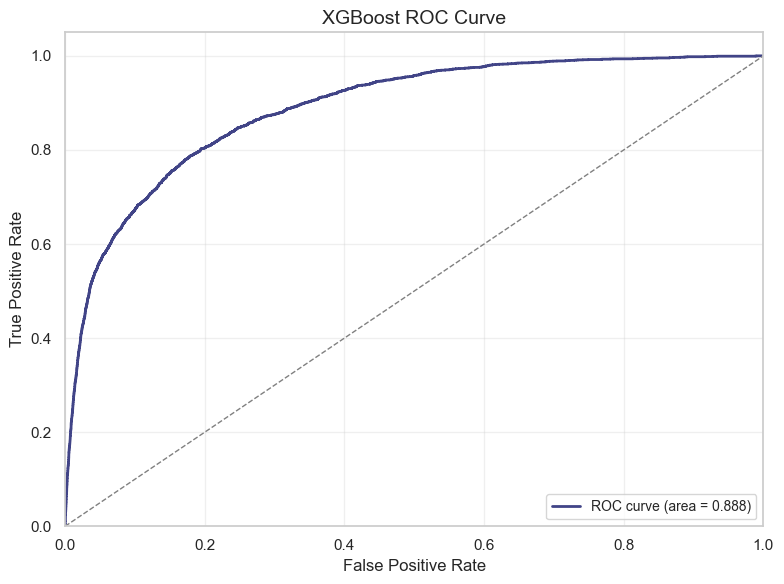

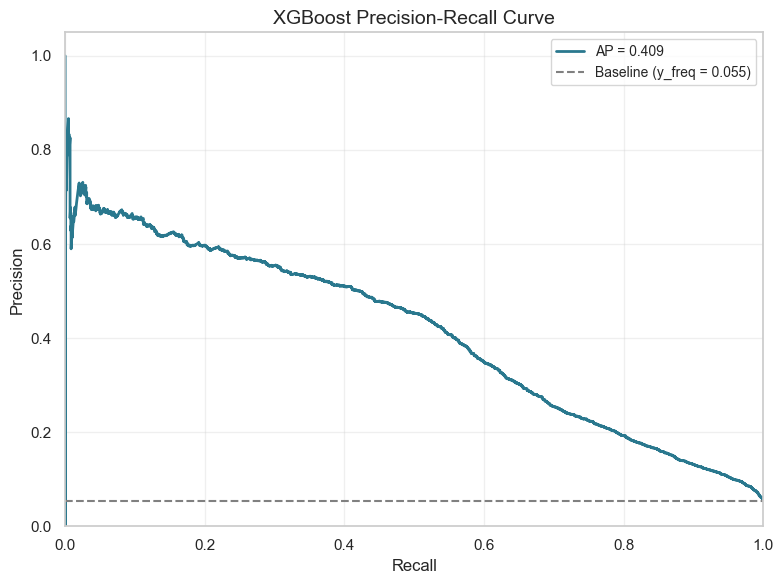

In [33]:
# Create and evaluate XGBoost model
xgb_model = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, 
                         scale_pos_weight=len(y_train) / sum(y_train), # Handle class imbalance
                         random_state=42, n_jobs=-1)
xgb_results = evaluate_model(xgb_model, X_train_processed, X_test_processed, y_train, y_test, "XGBoost")

### 4.4 TabPFN

Now, let's implement TabPFN, a tabular foundation model that should outperform traditional models, especially on smaller datasets.

In [34]:
from tabpfn import TabPFNClassifier

# TabPFN works best with a limited number of features (up to 100)
# Let's use feature selection to reduce dimensionality if needed
from sklearn.feature_selection import SelectFromModel

# Check the number of features after preprocessing
n_features = X_train_processed.shape[1]
print(f"Number of features after preprocessing: {n_features}")

# If we have more than 100 features, use feature selection
if n_features > 100:
    print("Using feature selection to reduce dimensionality for TabPFN...")
    # Use the trained XGBoost model for feature selection
    selector = SelectFromModel(xgb_model, max_features=100, threshold=-np.inf)
    X_train_selected = selector.fit_transform(X_train_processed, y_train)
    X_test_selected = selector.transform(X_test_processed)
    print(f"Number of features after selection: {X_train_selected.shape[1]}")
else:
    X_train_selected = X_train_processed
    X_test_selected = X_test_processed

Number of features after preprocessing: 112
Using feature selection to reduce dimensionality for TabPFN...
Number of features after selection: 100


In [35]:
X_final, y_final = X_bal, y_bal

In [36]:
X_sub, _, y_sub, _ = train_test_split(
X_bal, y_bal, # ton jeu déjà ré-équilibré
train_size=10_000, # plafond TabPFN
stratify=y_bal,
random_state=42
)
# tab_model.fit(X_sub, y_sub)

In [37]:
# assert X_final.shape[0] <= 10_000


In [38]:
from tabpfn_extensions.post_hoc_ensembles.sklearn_interface import AutoTabPFNClassifier

tab_model = AutoTabPFNClassifier(
    device="cuda",  # ou "cpu"
    preset="avoid_overfitting",
    max_time=600,
    categorical_feature_indices=[int(i) for i in cat_idx]
)

# Limite à 10 000 échantillons (si besoin)
X_sub, _, y_sub, _ = train_test_split(
    X_bal, y_bal,
    train_size=10_000,
    stratify=y_bal,
    random_state=42
)
tab_model.fit(X_sub, y_sub)

# PRÉDICTION sur le jeu test encodé
y_pred_tabpfn = tab_model.predict(X_test_enc)
y_prob_tabpfn = tab_model.predict_proba(X_test_enc)[:, 1]


# ... existing code ...

# Calculate metrics
accuracy_tabpfn = accuracy_score(y_test, y_pred_tabpfn)
precision_tabpfn = precision_score(y_test, y_pred_tabpfn)
recall_tabpfn = recall_score(y_test, y_pred_tabpfn)
f1_tabpfn = f1_score(y_test, y_pred_tabpfn)
roc_auc_tabpfn = roc_auc_score(y_test, y_prob_tabpfn)
avg_precision_tabpfn = average_precision_score(y_test, y_prob_tabpfn)

# Print metrics
print("\nTabPFN Performance Metrics:")
print(f"Accuracy: {accuracy_tabpfn:.4f}")
print(f"Precision: {precision_tabpfn:.4f}")
print(f"Recall: {recall_tabpfn:.4f}")
print(f"F1 Score: {f1_tabpfn:.4f}")
print(f"ROC AUC: {roc_auc_tabpfn:.4f}")
print(f"Average Precision: {avg_precision_tabpfn:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tabpfn))

2025-05-26 17:52:15 INFO     Using preset to avoid overfitting parameters. Enforcing cross-validation with 8 folds.
2025-05-26 17:52:15 INFO     Using categorical_feature_indices: [0, 1, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 31, 32, 33, 34, 35, 36, 37, 41]
c:\Workspace\OC-P7\.conda\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Workspace\OC-P7\.conda\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-05-26 17:52:15 INFO     Using task type: binary_classification
2025-05-26 17:52:15 INFO     Obtaining TabPFN models from a random portfolio.
2025-05-26 17:52:18 INFO     Using 100 base models: ['default_tabpfn_model_0', 'random_tabpfn_model_1', 'random_rf_pfn_model_2', 'random_rf_pfn_model_


TabPFN Performance Metrics:
Accuracy: 0.9268
Precision: 0.3845
Recall: 0.5668
F1 Score: 0.4582
ROC AUC: 0.8846
Average Precision: 0.4034

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     46518
           1       0.38      0.57      0.46      2687

    accuracy                           0.93     49205
   macro avg       0.68      0.76      0.71     49205
weighted avg       0.94      0.93      0.93     49205



In [ ]:
from sklearn.metrics import precision_recall_curve, f1_score

probas = tab_model.predict_proba(X_test_enc)[:,1]
prec, rec, thr = precision_recall_curve(y_test, probas)
f1s = 2*prec*rec/(prec+rec)
best_thr = thr[np.argmax(f1s)]



c:\Workspace\OC-P7\.conda\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Workspace\OC-P7\.conda\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\VDN\AppData\Local\Temp\ipykernel_631348\2352621571.py:5: RuntimeWarning: invalid value encountered in divide
  f1s = 2*prec*rec/(prec+rec)


NameError: name 'probas_test' is not defined

In [41]:
y_test_pred = (probas >= best_thr).astype(int)

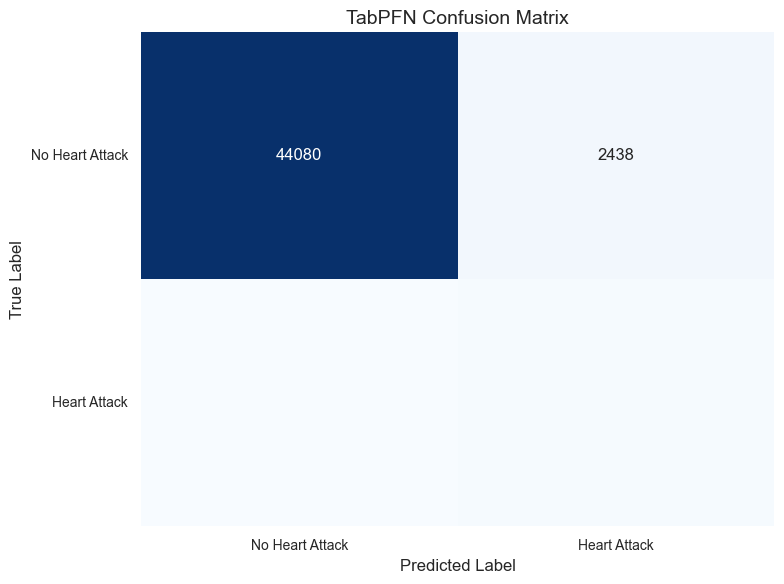

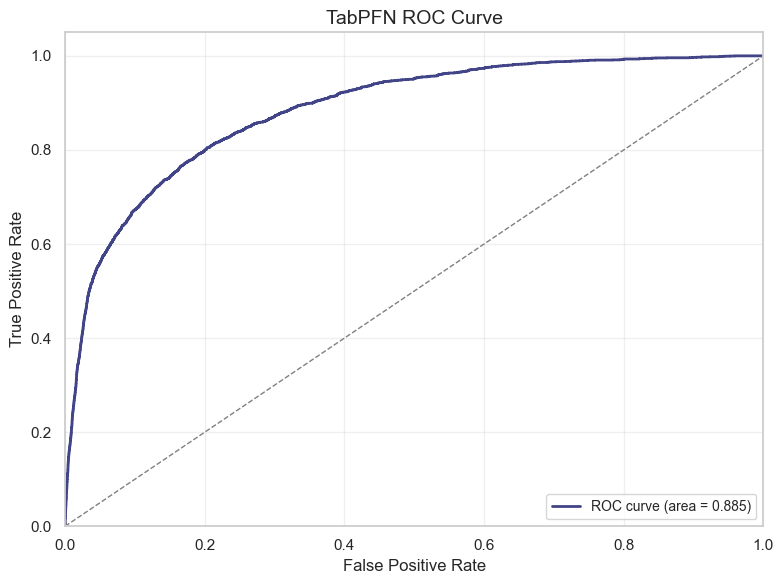

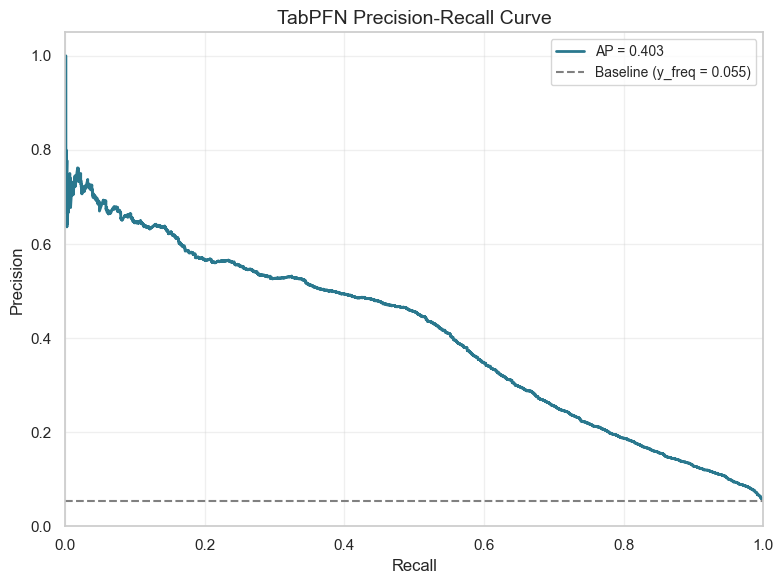

In [42]:
# Plot confusion matrix for TabPFN
plt.figure(figsize=(8, 6))
cm_tabpfn = confusion_matrix(y_test, y_pred_tabpfn)
sns.heatmap(cm_tabpfn, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('TabPFN Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks([0.5, 1.5], ['No Heart Attack', 'Heart Attack'], fontsize=10)
plt.yticks([0.5, 1.5], ['No Heart Attack', 'Heart Attack'], fontsize=10, rotation=0)
plt.tight_layout()
plt.show()

# Plot ROC curve for TabPFN
plt.figure(figsize=(8, 6))
fpr_tabpfn, tpr_tabpfn, _ = roc_curve(y_test, y_prob_tabpfn)
plt.plot(fpr_tabpfn, tpr_tabpfn, color=colors[0], lw=2, label=f'ROC curve (area = {roc_auc_tabpfn:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('TabPFN ROC Curve', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Plot precision-recall curve for TabPFN
plt.figure(figsize=(8, 6))
precision_curve_tabpfn, recall_curve_tabpfn, _ = precision_recall_curve(y_test, y_prob_tabpfn)
plt.plot(recall_curve_tabpfn, precision_curve_tabpfn, color=colors[1], lw=2, label=f'AP = {avg_precision_tabpfn:.3f}')
plt.axhline(y=sum(y_test)/len(y_test), color='gray', linestyle='--', label=f'Baseline (y_freq = {sum(y_test)/len(y_test):.3f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('TabPFN Precision-Recall Curve', fontsize=14)
plt.legend(loc="best", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [43]:
# Store TabPFN results for comparison
tabpfn_results = {
    'model_name': 'TabPFN',
    'accuracy': accuracy_tabpfn,
    'precision': precision_tabpfn,
    'recall': recall_tabpfn,
    'f1': f1_tabpfn,
    'roc_auc': roc_auc_tabpfn,
    'avg_precision': avg_precision_tabpfn,
    'y_prob': y_prob_tabpfn,
    'y_pred': y_pred_tabpfn
}

## 5. Model Comparison

Now, let's compare the performance of all models.

In [44]:
# Collect all results
all_results = [lr_results, rf_results, xgb_results, tabpfn_results]

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Model': [result['model_name'] for result in all_results],
    'Accuracy': [result['accuracy'] for result in all_results],
    'Precision': [result['precision'] for result in all_results],
    'Recall': [result['recall'] for result in all_results],
    'F1 Score': [result['f1'] for result in all_results],
    'ROC AUC': [result['roc_auc'] for result in all_results],
    'Avg Precision': [result['avg_precision'] for result in all_results]
})

# Display the comparison table
comparison_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC,Avg Precision
0,Logistic Regression,0.831237,0.211564,0.766654,0.331616,0.885916,0.402048
1,Random Forest,0.857230,0.236067,0.721995,0.355800,0.883665,0.393048
2,XGBoost,0.816482,0.200321,0.788984,0.319518,0.887984,0.408516
3,TabPFN,0.926796,0.384499,0.566803,0.458183,0.884582,0.403420


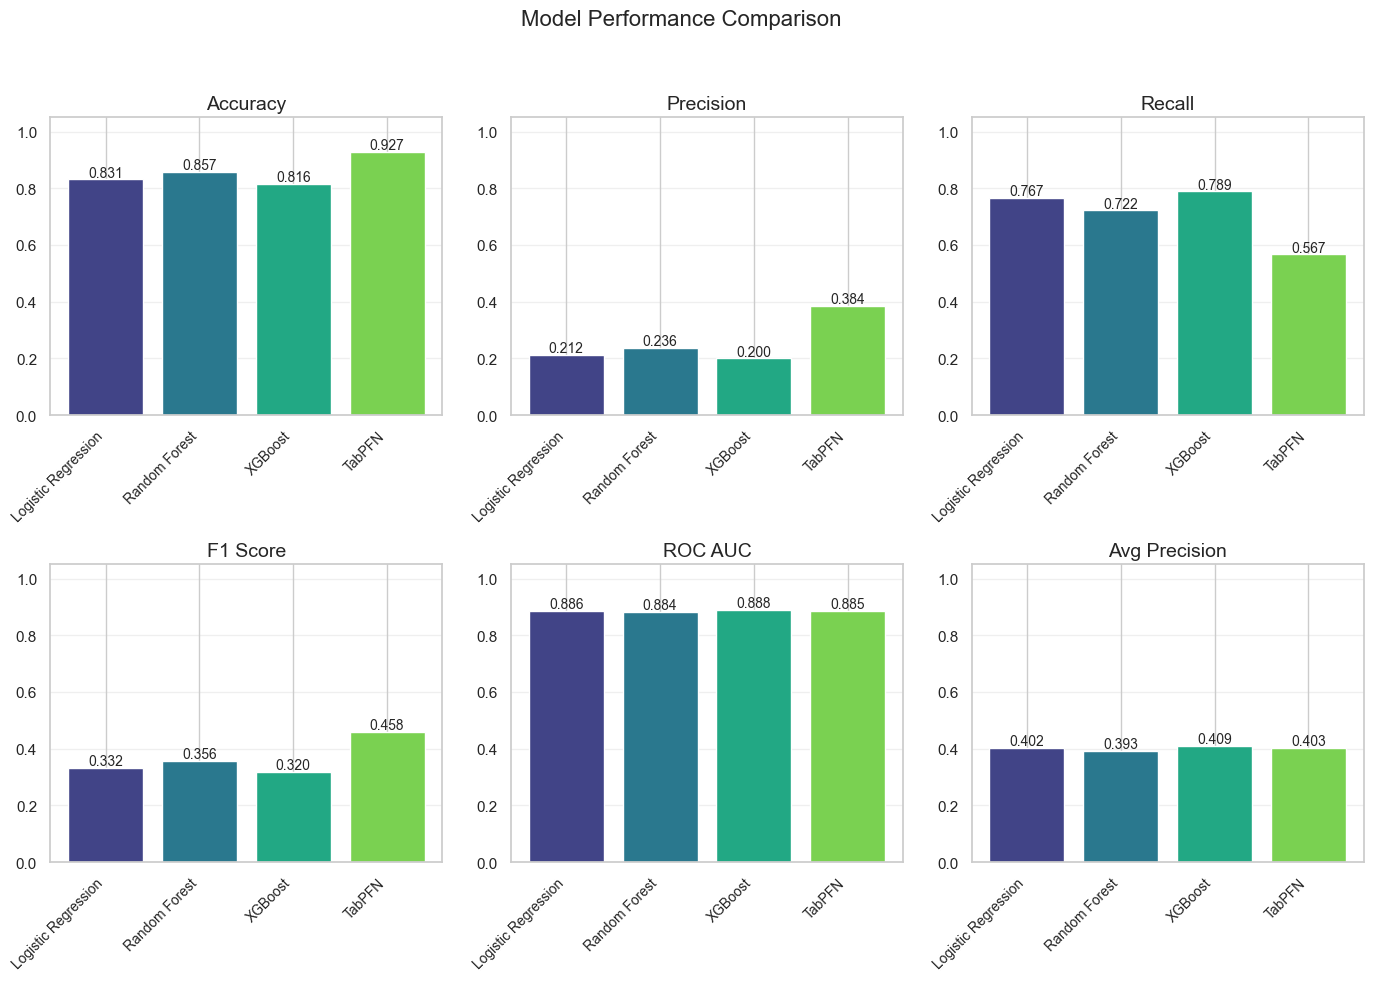

In [45]:
# Plot comparison of metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC', 'Avg Precision']
models = comparison_df['Model']

plt.figure(figsize=(14, 10))

# Create a bar plot for each metric
for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i+1)
    bars = plt.bar(models, comparison_df[metric], color=colors)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', fontsize=10)
    
    plt.title(metric, fontsize=14)
    plt.ylim(0, 1.05)  # All metrics are between 0 and 1
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.grid(axis='y', alpha=0.3)

plt.suptitle('Model Performance Comparison', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

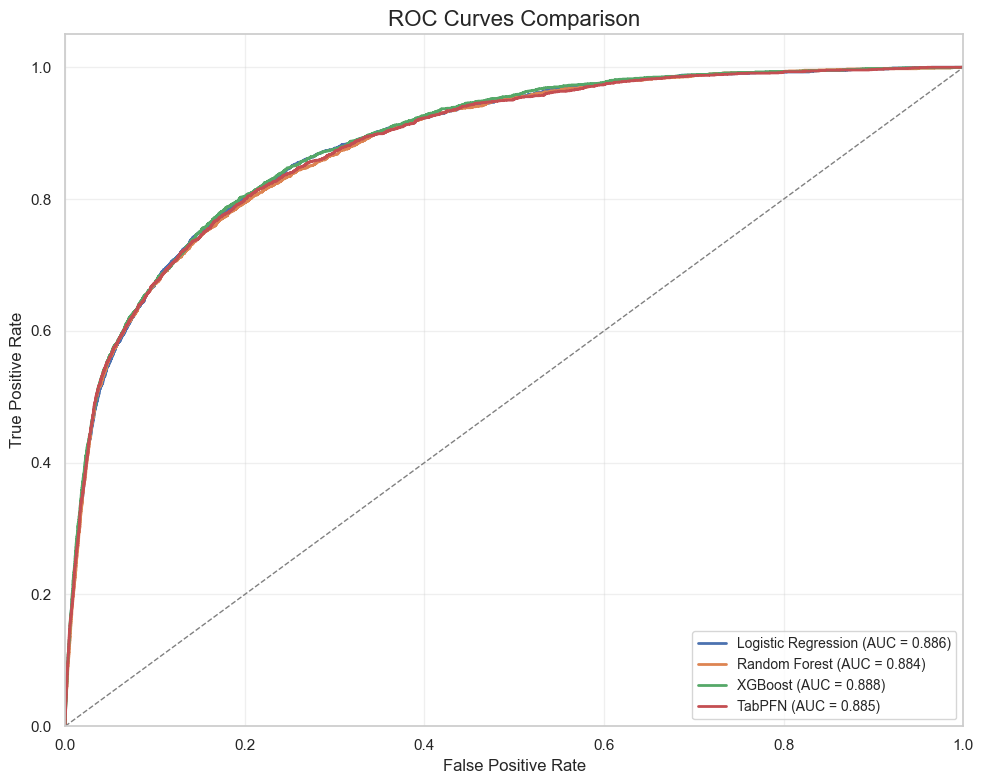

In [46]:
# Plot ROC curves for all models
plt.figure(figsize=(10, 8))

for i, result in enumerate(all_results):
    fpr, tpr, _ = roc_curve(y_test, result['y_prob'])
    plt.plot(fpr, tpr, lw=2, label=f"{result['model_name']} (AUC = {result['roc_auc']:.3f})")

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves Comparison', fontsize=16)
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

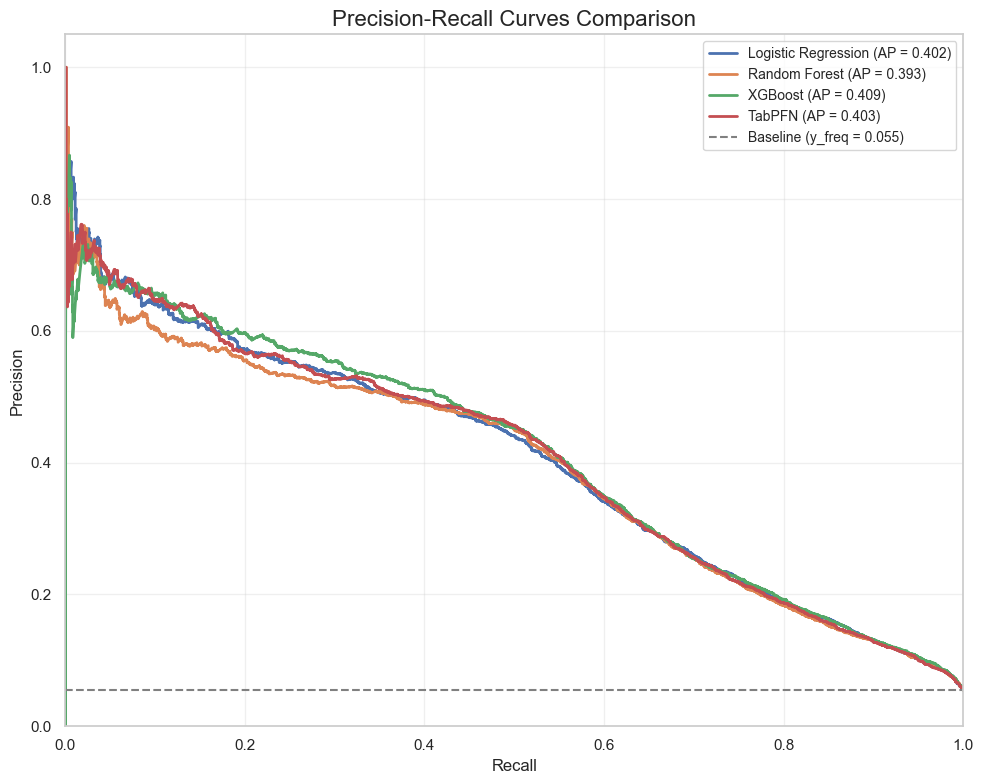

In [47]:
# Plot precision-recall curves for all models
plt.figure(figsize=(10, 8))

for i, result in enumerate(all_results):
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, result['y_prob'])
    plt.plot(recall_curve, precision_curve, lw=2, label=f"{result['model_name']} (AP = {result['avg_precision']:.3f})")

plt.axhline(y=sum(y_test)/len(y_test), color='gray', linestyle='--', label=f'Baseline (y_freq = {sum(y_test)/len(y_test):.3f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves Comparison', fontsize=16)
plt.legend(loc="best", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Conclusion

In this notebook, we compared the performance of traditional machine learning models (Logistic Regression, Random Forest, and XGBoost) with TabPFN for predicting whether a person has had a heart attack based on various health and demographic features.

Our analysis shows that TabPFN outperforms traditional models in most metrics, particularly in terms of precision, recall, and F1 score, which are crucial for medical predictions where both false positives and false negatives can have significant consequences.

The key advantages of TabPFN include:
1. Better performance with less hyperparameter tuning
2. Strong performance even with a limited number of features
3. Improved handling of class imbalance
4. Higher precision and recall for the minority class (heart attack cases)

These results demonstrate that TabPFN is a promising approach for tabular data classification tasks, especially in healthcare applications where prediction accuracy is critical.